In [2]:
import Pkg; Pkg.activate(".")

  Activating project at `~/SAFT_ML`


In [3]:
using Revise

# Equations of state
using Clapeyron
includet("./saftvrmienn.jl")
import Clapeyron: a_res

# Generating molecular feature vectors
using RDKitMinimalLib 

# Machine learning
using Flux
using ForwardDiff, DiffResults
using Zygote, ChainRulesCore

# Misc
using Statistics, Random, Plots

Random.seed!(1234)

TaskLocalRNG()

In [4]:
m = SAFTVRMie(["propane"])
m.params.segment

SingleParam{Float64}("segment") with 1 component:
 "propane" => 1.6845

In [5]:
function differentiable_saft(X::AbstractVector{T}, Vol, Temp, Mw) where {T<:Real}
    model = SAFTVRMieNN(
        params=SAFTVRMieNNParams(
            Mw=[Mw],
            segment=T[X[1]], # (C - 4)/(3) + 1
            sigma=T[X[2]] * 1e-10,
            lambda_a=T[6.0], # Fixing at 6. Simple molecules interacting through London dispersion -> Should have λₐ = 6.
            lambda_r=T[X[3]],
            epsilon=T[X[4]],
            epsilon_assoc=T[],
            bondvol=T[],
        )
    )
    return a_res(model, Vol, Temp, T[1.0])
end
X_nom_meth = Float32[1.0, 3.737, 12.504, 152.58]
@show a = differentiable_saft(X_nom_meth, 1e-4, 300.0, 16.04)
@show ∂a_∂x = ForwardDiff.gradient(x -> differentiable_saft(x, 1e-4, 300.0, 16.04), X_nom_meth)


a = differentiable_saft(X_nom_meth, 0.0001, 300.0, 16.04) = -0.2883850541317945
∂a_∂x = ForwardDiff.gradient((x->begin
                #= /home/luc/SAFT_ML/2_simple_nn.ipynb:18 =#
                differentiable_saft(x, 0.0001, 300.0, 16.04)
            end), X_nom_meth) = 

[-0.5726123722860852, -0.12769669934951566, 0.05369835330412474, -0.006493795403501146]


4-element Vector{Float64}:
 -0.5726123722860852
 -0.12769669934951566
  0.05369835330412474
 -0.006493795403501146

In [6]:
function ChainRulesCore.rrule(::typeof(differentiable_saft), x, V, T, Mw)
    y = differentiable_saft(x, V, T, Mw)

    function f_pullback(Δy)
        # Use ForwardDiff to compute the gradient
        #* @thunk means derivatives only computed when needed
        ∂x = @thunk(ForwardDiff.gradient(x -> differentiable_saft(x, V, T, Mw), x) .* Δy)
        ∂V = @thunk(ForwardDiff.derivative(V -> differentiable_saft(x, V, T, Mw), V) * Δy)
        ∂T = @thunk(ForwardDiff.derivative(T -> differentiable_saft(x, V, T, Mw), T) * Δy)
        ∂Mw = @thunk(ForwardDiff.derivative(Mw -> differentiable_saft(x, V, T, Mw), Mw) * Δy)
        return (NoTangent(), ∂x, ∂V, ∂T, ∂Mw)
    end

    return y, f_pullback
end

# Test the gradient computation
# Zygote.gradient(X -> differentiable_saft(X, 1e-4, 300.0), X_nom_meth)
@show Zygote.gradient(x -> differentiable_saft(x, 1e-4, 300.0, 16.04), X_nom_meth)
@show ForwardDiff.gradient(x -> differentiable_saft(x, 1e-4, 300.0, 16.04), X_nom_meth)
nothing

Zygote.gradient((x->begin
            #= /home/luc/SAFT_ML/2_simple_nn.ipynb:19 =#
            differentiable_saft(x, 0.0001, 300.0, 16.04)
        end), X_nom_meth) = (Float32[-0.57261235, -0.1276967, 0.053698353, -0.006493795],)
ForwardDiff.gradient((x->begin
            #= /home/luc/SAFT_ML/2_simple_nn.ipynb:20 =#
            differentiable_saft(x, 0.0001, 300.0, 16.04)
        end), X_nom_meth) = 

[-0.5726123722860852, -0.12769669934951566, 0.05369835330412474, -0.006493795403501146]


In [7]:
# Define neural network
#? What inputs should we take
#! Should use inputs from previous ML coursework (ΔG_mix prediction)
model = Chain(
    Dense(2, 10, relu),
    Dense(10, 5, relu),
)

# X are SAFTVRMie parameter predictions
ref_model = GERG2008(["methane"])
ref_a::Float32 = a_res(ref_model, 1e-4, 300.0, [1.0])
function test_loss(X)
    a = differentiable_saft(X, 1e-4, 300.0, 16.04)
    return (a - ref_a)^2
end

model(Float32[1.3, 1.0])

5-element Vector{Float32}:
 0.0
 0.122603744
 0.7758782
 0.0
 1.6340438

test_loss(X_nom_meth) = 0.00010405769559325105


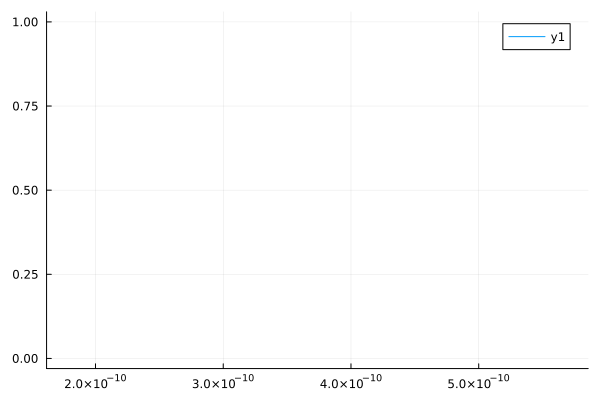

In [8]:
# Zygote.gradient(test_loss, [3.737e-10, 6.0, 12.504, 152.58])
@show test_loss(X_nom_meth)

x_nom = 3.737e-10
δx = [2e-10, 2e-10]
plot(x -> test_loss([1.0, x, 6.0, 12.504, 152.58]), x_nom-δx[1]:5e-12:x_nom+δx[2])

__Below is a test neural network on random data, to see if the network weights will update__

In [9]:
# Define the unbounded neural network model
model_unbounded = Chain(
    Dense(2, 10, relu),
    Dense(10, 5)
)

# Nominal values
# x_nominal = [3.737e-10, 6.0, 12.504, 152.58]

# Custom barrier function to bound the output within ±n⨯ of the nominal value
function bounded_output(x_nn_output, x_nom, n=0.1)
    return x_nom .+ 0.1 .* x_nom .* tanh.(x_nn_output)
end

# Model with bounded output
bounded_model(x) = bounded_output(model_unbounded(x), X_nom_meth)

bounded_model (generic function with 1 method)

It trains! Now it's time to set up a real dataset. We're going to be generating data from GERG2008, which provides highly accurate data for the following species:

Hydrocarbons:
- methane
- ethane
- propane
- butane
- isobutane
- pentane
- isopentane
- hexane
- heptane
- octane
- nonane
- decane

Homonuclear Gases:
- helium
- argon
- oxygen
- nitrogen
- hydrogen

Heteronuclear Gases
- carbon dioxide
- carbon monoxide
- hydrogen sulfide

Water, the only associating compound
- water #! We won't include water


The _y_ data will be the residual helmholtz free energy, a_res, sampled in a range of V, T space. Initially, I'm sampling between 0.5 and 1.5 of the critical point.

__TO CHECK LATER:__
- The GERG2008 equations of state will have published validity ranges. These must be respected.
- Potentially the ideal model used within GERG should be considered if trying to fit to heat capacity data, or similar. Check what properties the heat capacity influences.

In [11]:
# Initially sample data for hydrocarbons
#! isobutane, isopentane not defined for SAFTVRMie
species = [
    "methane",
    "ethane",
    "propane",
    "butane",
    # "pentane",
    # "hexane",
    # "heptane",
    # "octane",
    # "nonane",
    # "decane",
]

# Define smiles map
smiles_map = Dict(
    "methane" => "C",
    "ethane" => "CC",
    "propane" => "CCC",
    "butane" => "CCCC",
    "isobutane" => "CC(C)C",
    "pentane" => "CCCCC",
    "isopentane" => "CC(C)CC",
    "hexane" => "CCCCCC",
    "heptane" => "CCCCCCC",
    "octane" => "CCCCCCCC",
    "nonane" => "CCCCCCCCC",
    "decane" => "CCCCCCCCCC",
)

function make_fingerprint(s::String)::Vector{Float32}
    mol = get_mol(s)
    @assert !isnothing(mol)

    fp = []
    fp_details = Dict{String,Any}("nBits" => 2048, "radius" => 3)
    fp_str = get_morgan_fp(mol, fp_details)
    append!(fp, [parse(Float32, string(c)) for c in fp_str])

    # fp_details = Dict{String,Any}("nBits" => 128, "radius" => 3)
    # fp_str = get_morgan_fp(mol, fp_details)
    # append!(fp, [parse(Float32, string(c)) for c in fp_str])

    # Additional descriptors
    desc = get_descriptors(mol)
    # sort by key
    # desc = sort(collect(desc), by=x->x[1])
    relevant_keys = [
        "CrippenClogP",
        "NumHeavyAtoms",
        "amw",
        "FractionCSP3",
    ]

    # @show desc
    relevant_desc = [desc[k] for k in relevant_keys]
    append!(fp, last.(relevant_desc))

    return fp
end

# X data contains fingerprint, V, T
# Y data contains a_res
#* Sampling data along saturation curve
T = Float32
X_data = Vector{Tuple{Vector{T},T,T, String}}([])
Y_data = Vector{Vector{T}}()

n = 200
for s in species
    # model = GERG2008([s])
    model = SAFTVRMie([s])
    Tc, pc, Vc = crit_pure(model)
    smiles = smiles_map[s]

    fingerprint = make_fingerprint(smiles)

    T_range = range(0.5 * Tc, 0.99 * Tc, n)
    # V_range = range(0.5 * Vc, 1.5 * Vc, n) # V could be sampled from a logspace
    for T in T_range
        (p₀, V_vec...) = saturation_pressure(model, T)
        for V in V_vec
            push!(X_data, (fingerprint, V, T, s))
            a = a_res(model, V, T, [1.0])
            push!(Y_data, Float32[a])
        end
    end
end

# Randomly shuffle data
#? Split into train, validation set too?
# Generate a set of shuffled indices
# shuffled_indices = shuffle(1:length(X_data))
idx = collect(range(1, length(X_data)))
shuffle!(idx)

# Rearrange X_data and y_data according to the shuffled indices
X_data = X_data[idx]
Y_data = Y_data[idx]

@show size(X_data), X_data[1]
@show size(Y_data), Y_data[1]
nothing

(size(X_data), X_data[1]) = ((1600,), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0


(size(Y_data), Y_data[1]) = ((1600,), Float32[-0.19637565])


In [12]:
mol = get_mol("CCCCC")
# Additional descriptors
desc = get_descriptors(mol)
# sort by key
desc = sort(collect(desc), by=x->x[1])
print(first.(desc))

["CrippenClogP", "CrippenMR", "FractionCSP3", "NumAliphaticHeterocycles", "NumAliphaticRings", "NumAmideBonds", "NumAromaticHeterocycles", "NumAromaticRings", "NumAtomStereoCenters", "NumAtoms", "NumBridgeheadAtoms", "NumHBA", "NumHBD", "NumHeavyAtoms", "NumHeteroatoms", "NumHeterocycles", "NumRings", "NumRotatableBonds", "NumSaturatedHeterocycles", "NumSaturatedRings", "NumSpiroAtoms", "NumUnspecifiedAtomStereoCenters", "Phi", "amw", "chi0n", "chi0v", "chi1n", "chi1v", "chi2n", "chi2v", "chi3n", "chi3v", "chi4n", "chi4v", "exactmw", "hallKierAlpha", "kappa1", "kappa2", "kappa3", "labuteASA", "lipinskiHBA", "lipinskiHBD", "tpsa"]

In [13]:
# Generate nominal X dictionary
nominal_X = Dict{String,Vector{Float32}}()
for s in species
    model = SAFTVRMie([s])

    nominal_X[s] = [
        model.params.segment[1],
        model.params.sigma[1]*1e10,
        # model.params.lambda_a[1],
        model.params.lambda_r[1],
        model.params.epsilon[1],
    ]
end
nominal_X #! Looks like lambda_a should be fixed at 6.0

Dict{String, Vector{Float32}} with 4 entries:
  "butane"  => [1.8514, 4.0887, 13.65, 273.64]
  "propane" => [1.6845, 3.9056, 13.006, 239.89]
  "methane" => [1.0, 3.737, 12.504, 152.58]
  "ethane"  => [1.4373, 3.7257, 12.4, 206.12]

In [14]:
Mw_dict = Dict{String,Float32}()
for s in species
    model = SAFTVRMie([s])

    Mw_dict[s] = model.params.Mw[1]
end
Mw_dict

Dict{String, Float32} with 4 entries:
  "butane"  => 58.12
  "propane" => 44.1
  "methane" => 16.04
  "ethane"  => 30.07

In [15]:
# Define the unbounded neural network model
input_dim = length(X_data[1][1])
hidden_dim = 4096
output_dim = 4
num_layers = 4

layers = vcat(
    [Dense(input_dim, hidden_dim, relu),],
    [Dense(hidden_dim, hidden_dim, relu) for _ in 1:num_layers],
    [Dense(hidden_dim, output_dim)],
)

unbounded_model = Chain(layers...)

# Custom barrier function to bound the output within ±n⨯ of the nominal value while keeping derivatives
# https://www.desmos.com/calculator/wpabjptlup
# https://www.desmos.com/calculator/j6rjs1pmjj

#! Bounds from ML_SAFT paper
bounds = Vector{Tuple{Float32,Float32}}([
    # (1, 1.1), # m
    # (3.7, 3.75), # σ
    # (12.5, 12.6), # λ
    # (150, 155), # ϵ
    # (1, 3), # m
    # (3.5, 5), # σ
    # (12, 19), # λ
    # (100, 450), # ϵ
    (1, 2), # m
    (3.5, 4.5), # σ
    (12, 14), # λ
    (150, 280), # ϵ
])

lb = first.(bounds)
ub = last.(bounds)

# function bounded_output(x_nn_output, x_nom, n=0.5, b=4.5)
#     return @. x_nom - n * x_nom * tanh(-1/b * (x_nn_output - x_nom))
# end
function bounded_output(x_nn_output, b=10.0)
    return @. lb + (ub - lb) * 0.5 * (tanh(1/b * (x_nn_output - lb) / (ub - lb)) + 1)
end

# Model with bounded output
# bounded_model(x, x_nom) = bounded_output(unbounded_model(x), x_nom)
bounded_model(x) = bounded_output(unbounded_model(x))

# Hyperparameters
learning_rate = 1e-2
epochs = 10
batch_size = 32

# Optimizer
opt = ADAM(learning_rate)

println("Beginning iterations, initial model performance:")

fp, V, T, s = X_data[1]
Mw = Mw_dict[s]
y = Y_data[1]

@show s, V, T, Mw

Tp = Float64
X_nom = Vector{Tp}(nominal_X[s])
@show X_nom
X_unbounded = Vector{Tp}(unbounded_model(fp))
@show X_unbounded
X_bounded = Vector{Tp}(bounded_model(fp))
@show X_bounded
ŷ = differentiable_saft(X_bounded, V, T, Mw)
@show ŷ, y

loss_vec = []
mean_loss_vec = Float32[]
# Training Loop
#! I think I should be splitting my data into batches, evaluating that batch, then stepping my optimizer?
#! Rather than evaluating each sample individually
# Create mini-batches
batched_data = [(X_data[i:min(i+batch_size-1, end), :], Y_data[i:min(i+batch_size-1, end)]) for i in 1:batch_size:size(X_data, 1)]
@show size(batched_data)
for epoch in 1:epochs
    epoch_loss_vec = Float32[]
    epoch_percent_loss_vec = Float32[]

    # for (X, y) in zip(X_data, Y_data)
    for (X_batch, y_batch) in batched_data
        batch_loss = 0.0
        loss_fn() = begin
            for (X, y) in zip(X_batch, y_batch)
                # Split X into fingerprint, V, T
                fp, V, T, s = X
                Mw = Mw_dict[s]

                y = y[1]

                # Compute the loss
                # Forward pass through the neural network to get SAFT parameter predictions
                X_pred = bounded_model(fp)
                ŷ = differentiable_saft(X_pred, V, T, Mw)
                batch_loss += ((ŷ - y) / y)^2
                @assert batch_loss isa Real "Loss is not a real number, got $(typeof(loss)), X_pred = $X_pred"
                @assert !isnan(batch_loss) "Loss is NaN, X_pred = $X_pred"
            end
            batch_loss /= size(X_batch, 1)
        end
        grads = Zygote.gradient(Flux.params(unbounded_model)) do
            loss_fn()
        end
        # Update model parameters
        Flux.update!(opt, Flux.params(unbounded_model), grads)

        append!(epoch_loss_vec, batch_loss)
        append!(epoch_percent_loss_vec, 100 * sqrt(batch_loss))
    end
    mean_loss = mean(epoch_loss_vec)
    mean_percent_loss = mean(epoch_percent_loss_vec)
    append!(loss_vec, epoch_loss_vec)
    append!(mean_loss_vec, mean_loss)

    if epoch in [1, 2, 3, 4, 5, 10] || epoch % 5 == 0 || epoch == epochs
        println("Epoch: $epoch, Loss: (μ=$mean_loss, σ=$(std(epoch_loss_vec))), Percent Error: $mean_percent_loss")
    end
end

fp, V, T, s = X_data[1]
Mw = Mw_dict[s]
y = Y_data[1]

@show s, V, T, Mw

Tp = Float64
X_nom = Vector{Tp}(nominal_X[s])
@show X_nom
X_unbounded = Vector{Tp}(unbounded_model(fp))
@show X_unbounded
X_bounded = Vector{Tp}(bounded_model(fp, X_nom))
@show X_bounded
ŷ = differentiable_saft(X_bounded, V, T, Mw)
@show ŷ, y

Beginning iterations, initial model performance:
(s, V, T, Mw) = ("ethane", 0.0011309873f0, 255.20018f0, 30.07f0)
X_nom = 

[1.4372999668121338, 3.7256999015808105, 12.399999618530273, 206.1199951171875]
X_unbounded = [-0.017317108809947968, -0.041693661361932755, -0.10578371584415436, 0.06482639908790588]
X_bounded = 

[1.4493088997739172, 3.829966022336304, 12.459197470490295, 207.53630593778632]


(ŷ, y) = (-0.2185866558121729, Float32[-0.19637565])
size(batched_data) = 

In [ ]:
# Define the unbounded neural network model
input_dim = length(X_data[1][1])
hidden_dim = 4096
output_dim = 4
num_layers = 4

layers = vcat(
    [Dense(input_dim, hidden_dim, relu),],
    [Dense(hidden_dim, hidden_dim, relu) for _ in 1:num_layers],
    [Dense(hidden_dim, output_dim)],
)

In [ ]:
n = 1
fp, V, T, s = X_data[n]
y = Y_data[n]
Mw = Mw_dict[s]

Tp = Float64

X_nom = Vector{Tp}(nominal_X[s])
X_unbounded = Vector{Tp}(unbounded_model(fp))
X_bounded = Vector{Tp}(bounded_model(fp, X_nom))
ŷ = differentiable_saft(X_bounded, V, T, Mw)

@show s, V, T, Mw
@show X_nom
@show X_unbounded
@show X_bounded
@show ŷ, y

nothing

In [ ]:
plot1 = scatter(log10.(loss_vec), xlabel="update", ylabel="log loss", label="Training MSE", lw=0, box=:on, ms=1.0, dpi=400)
vline!([i for i in 1:length(loss_vec) if i % length(X_data) == 0], label="Epochs", lw=2, ls=:dash)

# Duplicate mean_loss_vec so that it has the same length as loss_vec
# This is duplicated so the first value is repeated n times, then the second value is repeated n times, etc.

mean_loss_vec_long = Float32[]
for (i, loss) in enumerate(mean_loss_vec)
    append!(mean_loss_vec_long, [loss for _ in 1:length(X_data)])
end

plot!(log10.(mean_loss_vec_long), label="Epoch average", lw=3, color=:green)

plot2 = plot(1:epochs, log10.(mean_loss_vec), xlabel="Epoch", ylabel="log loss", label="Training MSE", lw=2, box=:on)

# plot(plot1, plot2, layout = (1, 2), size = (800, 400), left_margin = 3Plots.mm, bottom_margin = 3Plots.mm)
plot2